Import Libraries

In [1]:
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split, learning_curve
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier, plot_tree
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import classification_report, accuracy_score
    from sklearn.feature_selection import SelectKBest, f_classif, RFE
    from sklearn.model_selection import GridSearchCV
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    from xgboost import XGBClassifier
    import shap  
    import skfuzzy as fuzz  



 Load Dataset and Preprocess Data

In [2]:
# Load the dataset
file_path = 'kidney_disease.csv'  # Update the path if needed
data = pd.read_csv(file_path)

# Clean target labels: Remove any trailing whitespace or tabs
data['classification'] = data['classification'].str.strip()

# Convert target labels to binary (1 for 'ckd', 0 for 'notckd')
data['classification'] = data['classification'].replace({'ckd': 1, 'notckd': 0})

# Split features (X) and target (y)
X = data.drop(columns=['id', 'classification'])  # Drop 'id' and target column
y = data['classification']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns



C:\Users\Desoky\AppData\Local\Temp\ipykernel_10160\882272973.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['classification'] = data['classification'].replace({'ckd': 1, 'notckd': 0})


Define Preprocessing Pipelines

In [3]:
# Cell 3: Define preprocessing steps for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)




Define Models and Search Spaces

In [4]:
# Define a dictionary of models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Define search spaces for hyperparameter optimization
search_spaces = {
    "Random Forest": {'n_estimators': Integer(50, 200), 'max_depth': Integer(5, 50), 'min_samples_split': Integer(2, 10)},
    "Gradient Boosting": {'n_estimators': Integer(50, 200), 'learning_rate': Real(0.01, 0.2), 'max_depth': Integer(3, 10)},
    "AdaBoost": {'n_estimators': Integer(50, 200), 'learning_rate': Real(0.01, 2)},
    "Support Vector Machine": {'C': Real(0.1, 10), 'gamma': Real(0.01, 1), 'kernel': ['rbf', 'linear']},
    "Logistic Regression": {'C': Real(0.01, 10), 'solver': ['lbfgs', 'liblinear']},
    "Decision Tree": {'max_depth': Integer(3, 10), 'min_samples_split': Integer(2, 10)},
    "Naive Bayes": {},  # No hyperparameters to tune
    "K-Nearest Neighbors": {'n_neighbors': Integer(3, 15), 'weights': ['uniform', 'distance']}
}



Feature Selection and Random State Loop

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats


# Your existing code remains unchanged
# Initialize results dictionary
all_results = {}

# Loop over different random states
random_states = [42]
for random_state in random_states:
    print(f"\nEvaluating models with random_state={random_state}...")
    results = {}

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True
    )

    # Preprocess data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Perform Feature Selection: SelectKBest
    k_best_selector = SelectKBest(score_func=f_classif, k=10)
    X_train_k_best = k_best_selector.fit_transform(X_train_preprocessed, y_train)
    X_test_k_best = k_best_selector.transform(X_test_preprocessed)

    # Perform Feature Selection: RFE
    rfe_selector = RFE(estimator=RandomForestClassifier(random_state=random_state), n_features_to_select=10)
    X_train_rfe = rfe_selector.fit_transform(X_train_preprocessed, y_train)
    X_test_rfe = rfe_selector.transform(X_test_preprocessed)

    # Evaluate models using both feature selection methods
    for method, (X_train_fs, X_test_fs) in {"SelectKBest": (X_train_k_best, X_test_k_best),
                                           "RFE": (X_train_rfe, X_test_rfe)}.items():
        print(f"\nUsing Feature Selection Method: {method}")
        optimized_models = {}

        # Hyperparameter optimization using BayesSearchCV
        for model_name, model in models.items():
            search_space = search_spaces[model_name]
            if not search_space:
                print(f"Skipping {model_name} (no hyperparameters to tune).")
                continue

            optimizer = BayesSearchCV(model, search_space, n_iter=20, cv=5, random_state=random_state, n_jobs=-1)
            optimizer.fit(X_train_fs, y_train)

            # Store the optimized model
            optimized_models[model_name] = optimizer
            print(f"Best parameters for {model_name}: {optimizer.best_params_}")

        # Evaluate each optimized model
        for model_name, optimizer in optimized_models.items():
            model = optimizer.best_estimator_
            y_pred = model.predict(X_test_fs)
            accuracy = accuracy_score(y_test, y_pred)
            results[(method, model_name)] = accuracy

    # Store results for current random state
    all_results[random_state] = results

# Create DataFrame for analysis
rows = []
for random_state in all_results:
    for (method, model_name), accuracy in all_results[random_state].items():
        rows.append({
            'Random State': random_state,
            'Feature Selection': method,
            'Model': model_name,
            'Accuracy': accuracy
        })

results_df = pd.DataFrame(rows)

# Calculate statistics
stats_df = results_df.groupby(['Model', 'Feature Selection'])['Accuracy'].agg(['mean', 'std']).round(4)
stats_pivot = stats_df.unstack()

# Calculate differences
rfe_results = stats_df.xs('RFE', level=1)
kbest_results = stats_df.xs('SelectKBest', level=1)
differences = (rfe_results - kbest_results).round(4)

# Perform t-tests
t_test_results = {}
for model in results_df['Model'].unique():
    rfe_scores = results_df[(results_df['Model'] == model) & 
                           (results_df['Feature Selection'] == 'RFE')]['Accuracy']
    kbest_scores = results_df[(results_df['Model'] == model) & 
                             (results_df['Feature Selection'] == 'SelectKBest')]['Accuracy']
    t_stat, p_value = stats.ttest_rel(rfe_scores, kbest_scores)
    t_test_results[model] = p_value




Evaluating models with random_state=42...


C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Using Feature Selection Method: SelectKBest
Best parameters for Random Forest: OrderedDict([('max_depth', 25), ('min_samples_split', 9), ('n_estimators', 66)])
Best parameters for Gradient Boosting: OrderedDict([('learning_rate', 0.1845892441626926), ('max_depth', 4), ('n_estimators', 168)])
Best parameters for AdaBoost: OrderedDict([('learning_rate', 0.8261068781180946), ('n_estimators', 159)])
Best parameters for Support Vector Machine: OrderedDict([('C', 4.503841871781403), ('gamma', 0.9195352964526833), ('kernel', 'rbf')])
Best parameters for Logistic Regression: OrderedDict([('C', 0.013045890403160385), ('solver', 'lbfgs')])
Best parameters for Decision Tree: OrderedDict([('max_depth', 9), ('min_samples_split', 3)])
Skipping Naive Bayes (no hyperparameters to tune).
Best parameters for K-Nearest Neighbors: OrderedDict([('n_neighbors', 5), ('weights', 'distance')])

Using Feature Selection Method: RFE
Best parameters for Random Forest: OrderedDict([('max_depth', 23), ('min_samples

C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Decision tree and  Fuzzy Rule Set-Based Explainability (XAI)

Loading dataset...

1. Decision Tree Analysis
------------------------


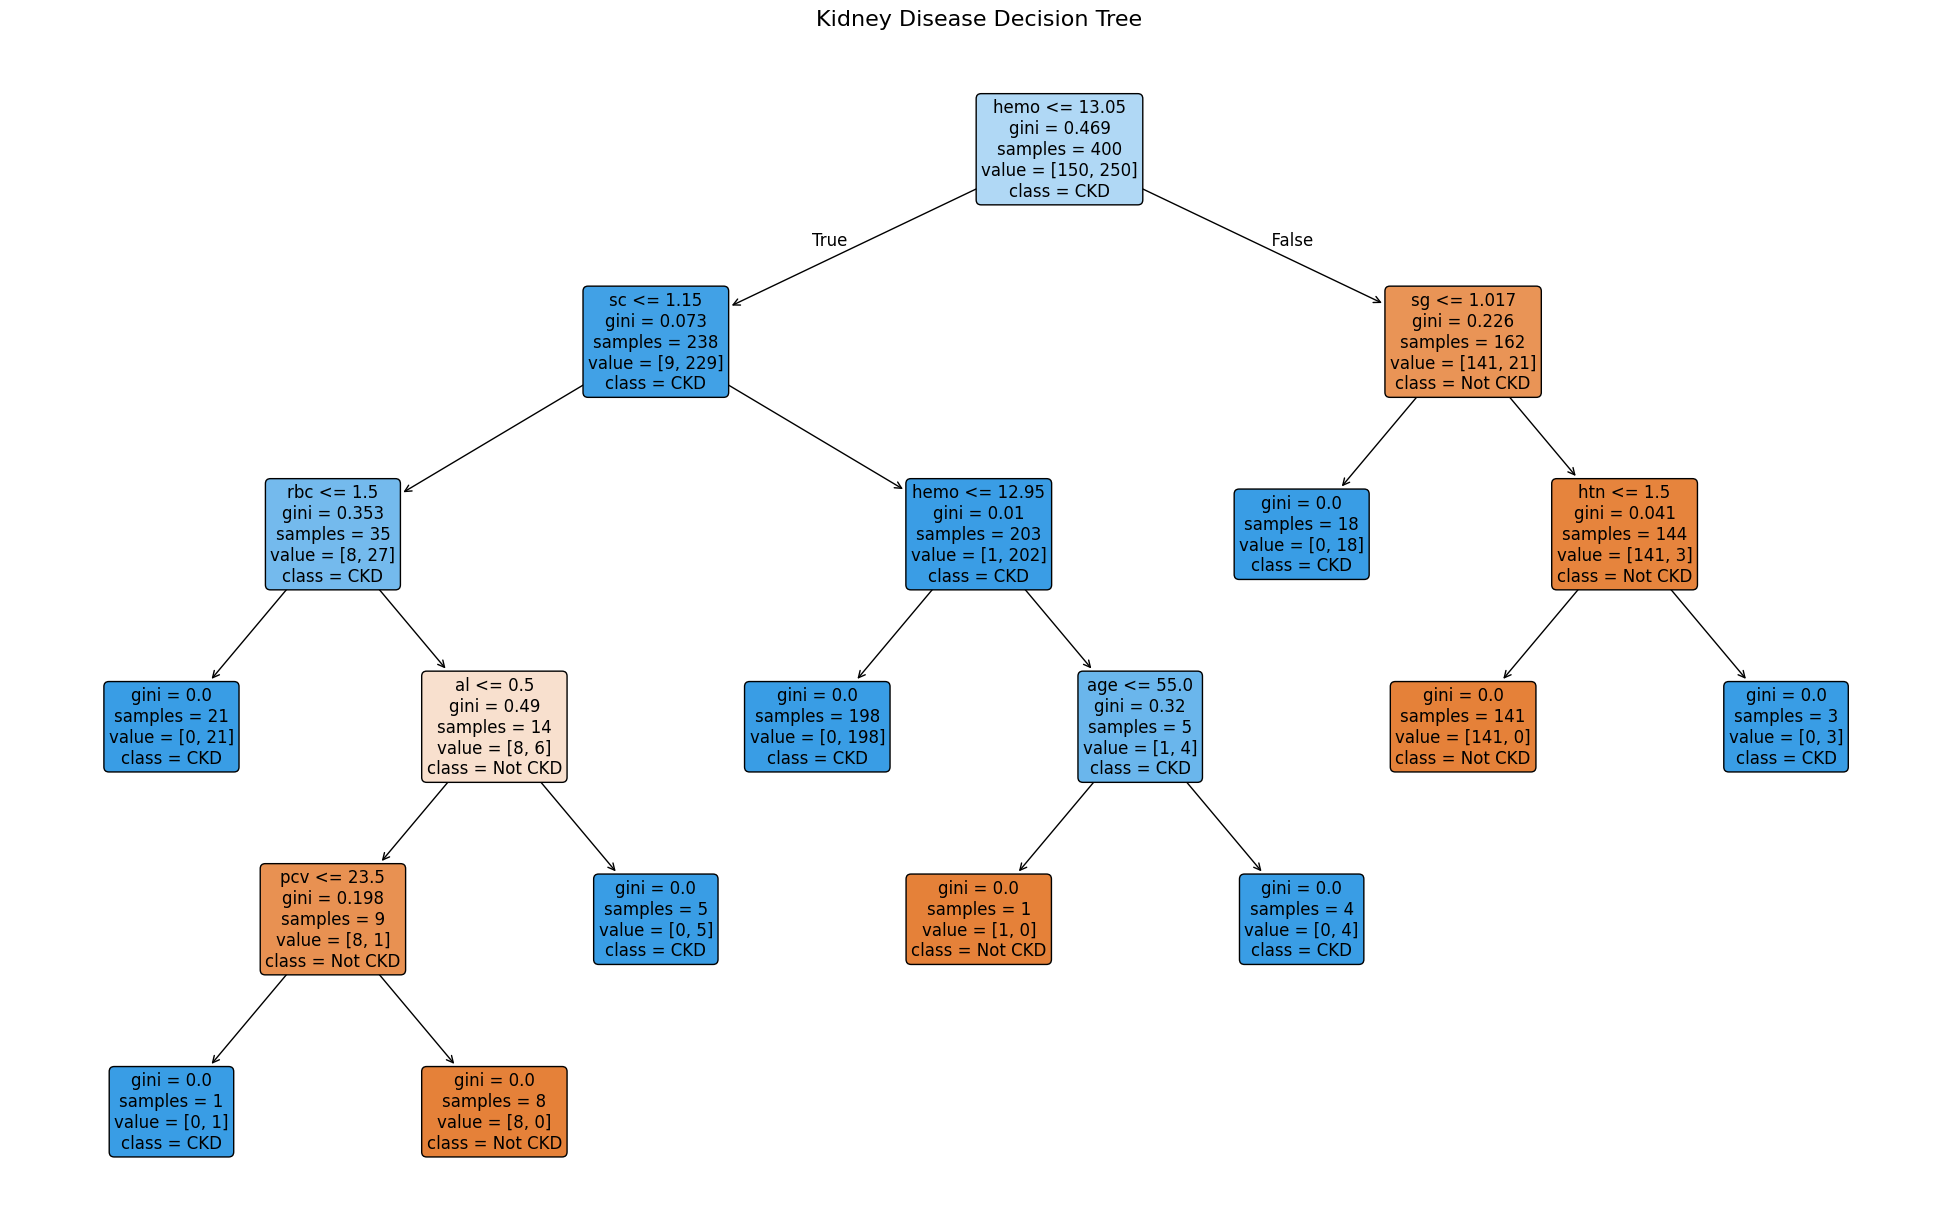


Decision Tree Path Equations:
-----------------------------

Path 1:
IF hemo <= 13.05 AND IF sc <= 1.15 AND IF rbc <= 1.50 THEN Risk of CKD = 100.00%

Path 2:
IF hemo <= 13.05 AND IF sc <= 1.15 AND IF rbc > 1.50 AND IF al <= 0.50 AND IF pcv <= 23.50 THEN Risk of CKD = 100.00%

Path 3:
IF hemo <= 13.05 AND IF sc <= 1.15 AND IF rbc > 1.50 AND IF al > 0.50 THEN Risk of CKD = 100.00%

Path 4:
IF hemo <= 13.05 AND IF sc > 1.15 AND IF hemo <= 12.95 THEN Risk of CKD = 100.00%

Path 5:
IF hemo <= 13.05 AND IF sc > 1.15 AND IF hemo > 12.95 AND IF age > 55.00 THEN Risk of CKD = 100.00%

Path 6:
IF hemo > 13.05 AND IF sg <= 1.02 THEN Risk of CKD = 100.00%

Path 7:
IF hemo > 13.05 AND IF sg > 1.02 AND IF htn > 1.50 THEN Risk of CKD = 100.00%

Mathematical Decision Function:
------------------------------

CKD Risk Score = Σ (Feature_Coefficient × Feature_Value)
hemo: 0.7147
sg: 0.1636
htn: 0.0313
rbc: 0.0293
al: 0.0271
sc: 0.0159
pcv: 0.0095
age: 0.0085
pe: 0.0000
appet: 0.0000
cad: 0.0000
dm: 0.

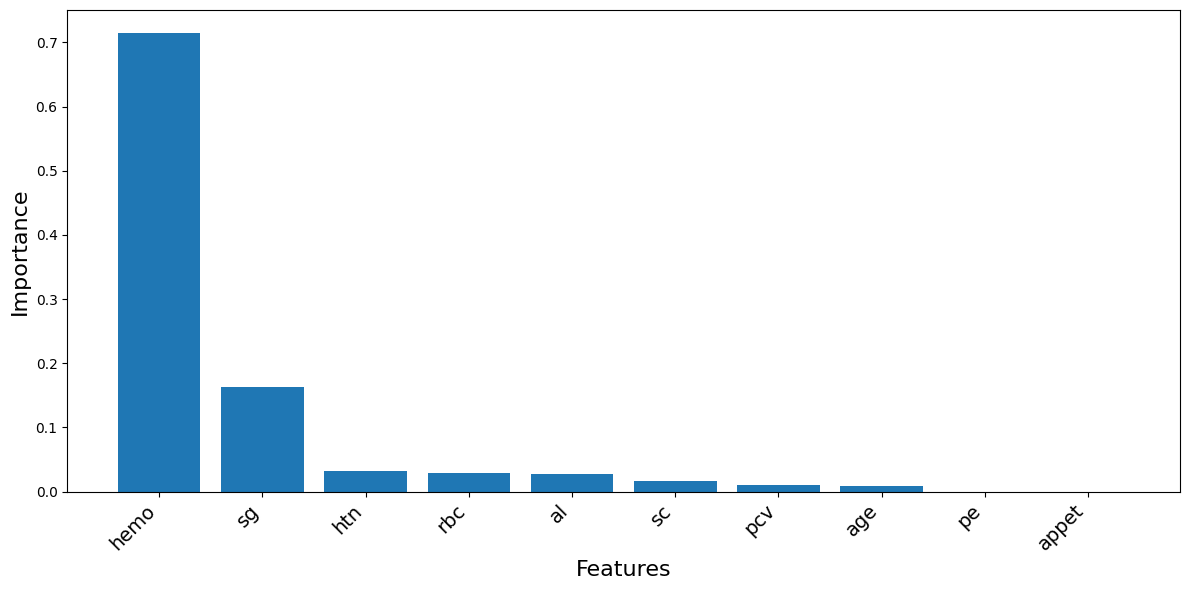


2. Random Forest Analysis
-------------------------


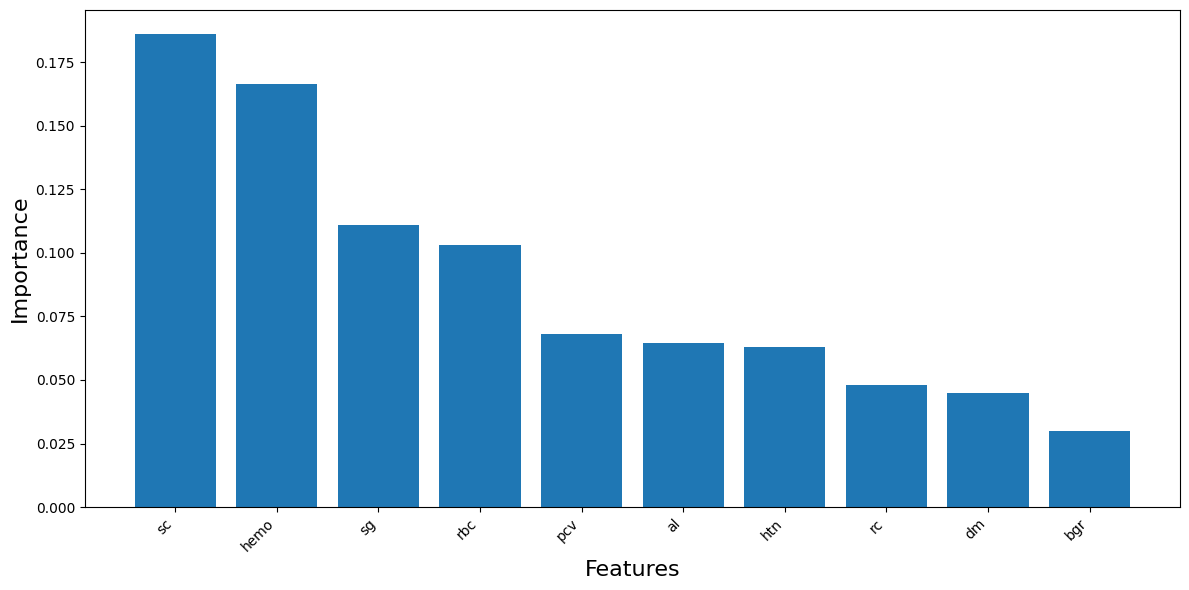


3. Combined Important Features Analysis
-------------------------------------

Decision Tree Top 10 Features:
-----------------------------
hemo: 0.7147
sg: 0.1636
htn: 0.0313
rbc: 0.0293
al: 0.0271
sc: 0.0159
pcv: 0.0095
age: 0.0085
pe: 0.0000
appet: 0.0000

Random Forest Top 10 Features:
----------------------------
sc: 0.1862
hemo: 0.1663
sg: 0.1108
rbc: 0.1032
pcv: 0.0681
al: 0.0644
htn: 0.0630
rc: 0.0481
dm: 0.0450
bgr: 0.0297

4. Fuzzy Rule Analysis for Important Features
------------------------------------------

Analyzing feature: age


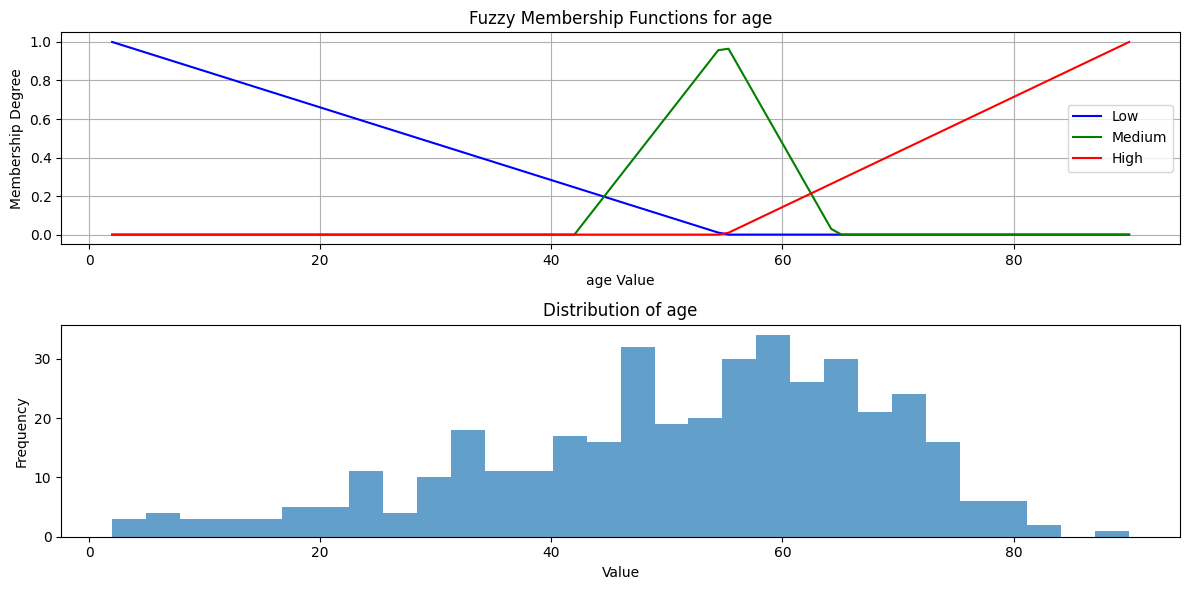

Statistics for age:
Min: 2.00
Q1: 42.00
Median: 55.00
Q3: 64.50
Max: 90.00

Analyzing feature: sc


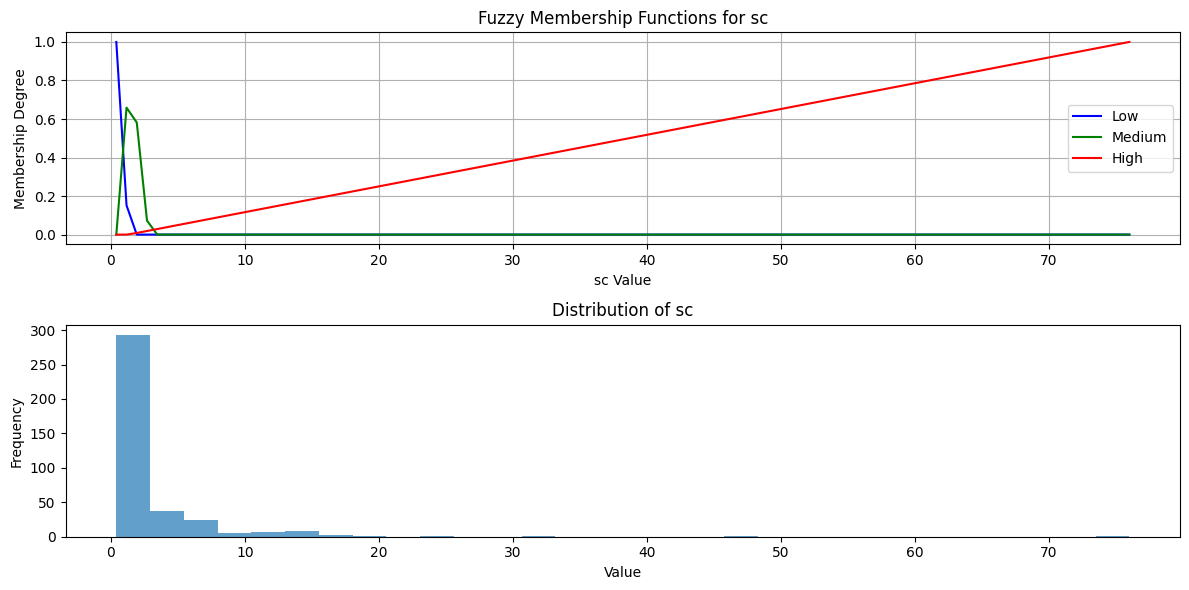

Statistics for sc:
Min: 0.40
Q1: 0.90
Median: 1.30
Q3: 2.80
Max: 76.00

Analyzing feature: al


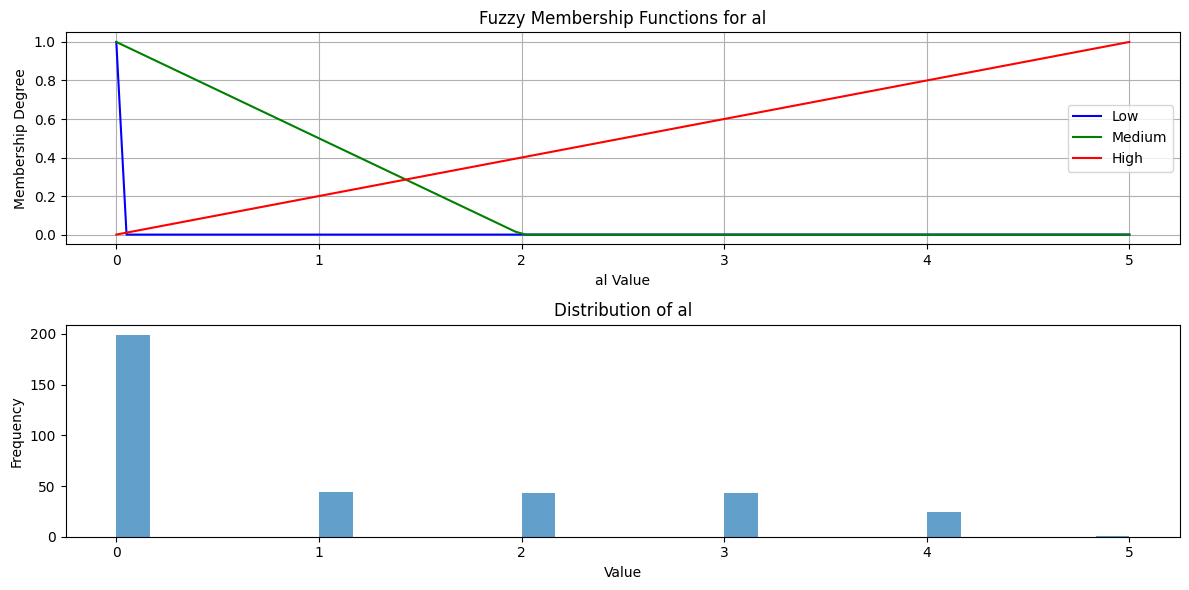

Statistics for al:
Min: 0.00
Q1: 0.00
Median: 0.00
Q3: 2.00
Max: 5.00

Analyzing feature: sg


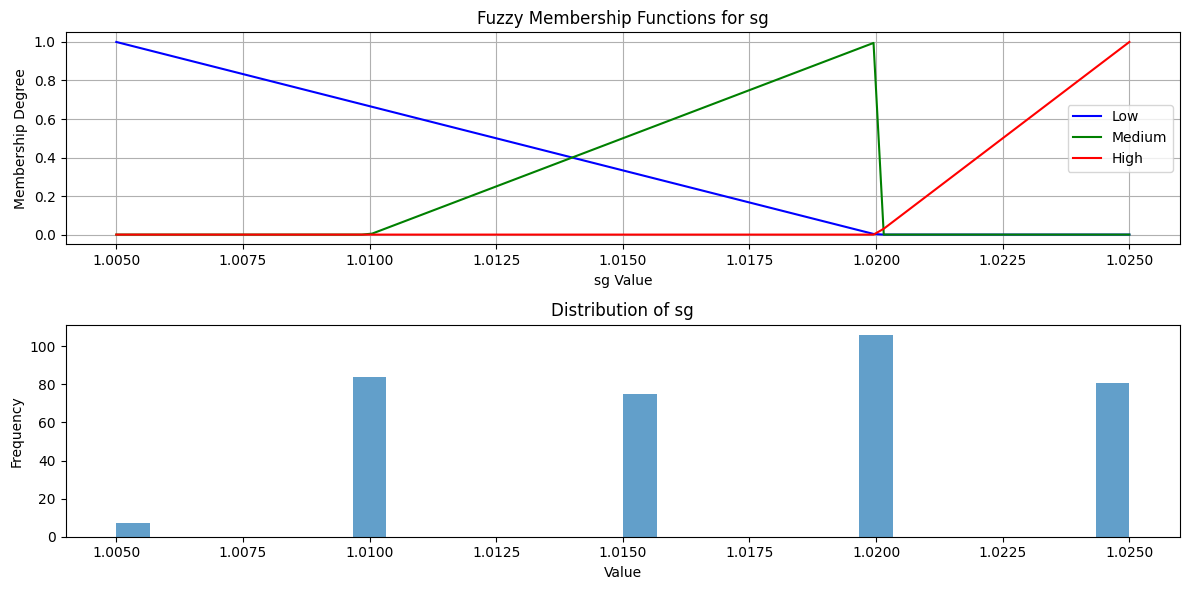

Statistics for sg:
Min: 1.00
Q1: 1.01
Median: 1.02
Q3: 1.02
Max: 1.02

Analyzing feature: hemo


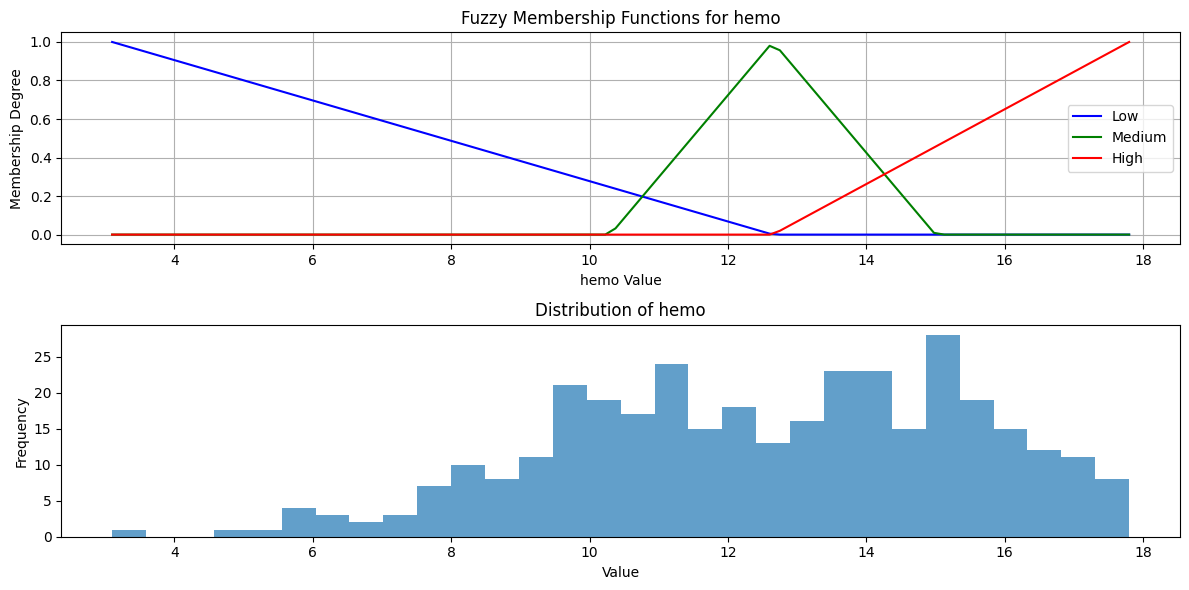

Statistics for hemo:
Min: 3.10
Q1: 10.30
Median: 12.65
Q3: 15.00
Max: 17.80

Analyzing feature: bgr


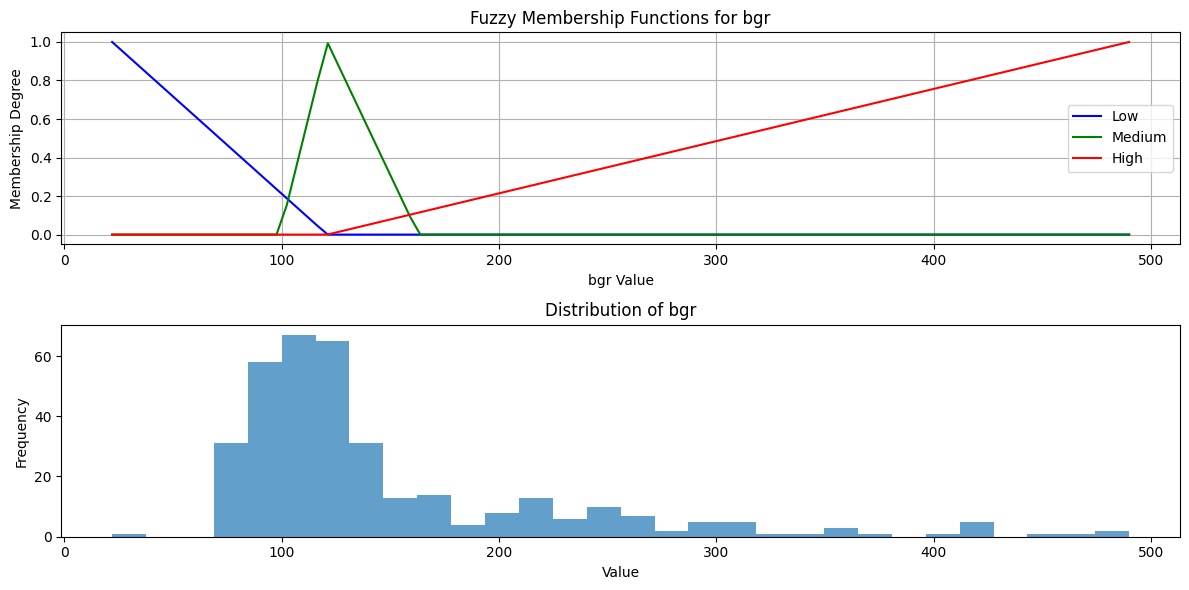

Statistics for bgr:
Min: 22.00
Q1: 99.00
Median: 121.00
Q3: 163.00
Max: 490.00

5. Detailed Fuzzy Rule Set Analysis
---------------------------------
Comprehensive IF-THEN Rules for Kidney Disease Classification:

Detailed Rules for hemo (Importance Weight: 0.4405):
IF hemo is LOW (< 10.30):
  → Risk Contribution: Low (membership degree * 0.4405)
  → Clinical Interpretation: Values below 10.30 suggest lower risk
IF hemo is MEDIUM (10.30 to 15.00):
  → Risk Contribution: Medium (membership degree * 0.4405)
  → Clinical Interpretation: Values between 10.30 and 15.00 indicate moderate risk
IF hemo is HIGH (> 15.00):
  → Risk Contribution: High (membership degree * 0.4405)
  → Clinical Interpretation: Values above 15.00 indicate elevated risk

Detailed Rules for sg (Importance Weight: 0.1372):
IF sg is LOW (< 1.01):
  → Risk Contribution: Low (membership degree * 0.1372)
  → Clinical Interpretation: Values below 1.01 suggest lower risk
IF sg is MEDIUM (1.01 to 1.02):
  → Risk Contribution:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler, LabelEncoder

class KidneyDiseaseXAI:
    def __init__(self):
        self.decision_tree = DecisionTreeClassifier(
            max_depth=9,
            min_samples_split=3,
            random_state=42
        )
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def preprocess_data(self, data):
        processed_data = data.copy()
        numeric_cols = processed_data.select_dtypes(include=['float64', 'int64']).columns
        for col in numeric_cols:
            processed_data[col] = pd.to_numeric(processed_data[col], errors='coerce')
            processed_data[col] = processed_data[col].fillna(processed_data[col].median())
            
        categorical_cols = processed_data.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            processed_data[col] = processed_data[col].fillna('missing')
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
            processed_data[col] = self.label_encoders[col].fit_transform(processed_data[col])
            
        return processed_data
    
    def get_decision_path_equations(self, tree, feature_names):
        """Extract decision path equations from the tree"""
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold
        value = tree.tree_.value
        
        def recurse(node, depth, path=""):
            equations = []
            
            if tree.tree_.feature[node] != -2:  # Not a leaf node
                name = feature_names[feature[node]]
                thresh = threshold[node]
                
                # Left path (<=)
                left_path = f"{path}IF {name} <= {thresh:.2f}"
                if children_left[node] != -1:
                    equations.extend(recurse(children_left[node], depth + 1, left_path + " AND "))
                    
                # Right path (>)
                right_path = f"{path}IF {name} > {thresh:.2f}"
                if children_right[node] != -1:
                    equations.extend(recurse(children_right[node], depth + 1, right_path + " AND "))
            else:  # Leaf node
                prob_ckd = value[node][0][1] / sum(value[node][0])
                if prob_ckd >= 0.5:
                    equations.append(f"{path[:-5]} THEN Risk of CKD = {prob_ckd:.2%}")
                
            return equations
        
        return recurse(0, 0)
    
    def visualize_decision_tree(self, X, y):
        X_processed = self.preprocess_data(X)
        self.decision_tree.fit(X_processed, y)
        
        plt.figure(figsize=(25, 15))
        plot_tree(self.decision_tree, 
                 feature_names=X_processed.columns, 
                 class_names=['Not CKD', 'CKD'],
                 filled=True,
                 rounded=True,
                 fontsize=12)
        plt.title("Kidney Disease Decision Tree", fontsize=16, pad=20)
        plt.show()
        
        # Generate and print decision path equations
        print("\nDecision Tree Path Equations:")
        print("-----------------------------")
        equations = self.get_decision_path_equations(self.decision_tree, X_processed.columns)
        for i, eq in enumerate(equations, 1):
            print(f"\nPath {i}:")
            print(eq)
            
        # Calculate and display mathematical decision function
        print("\nMathematical Decision Function:")
        print("------------------------------")
        feature_contributions = pd.DataFrame({
            'Feature': X_processed.columns,
            'Coefficient': self.decision_tree.feature_importances_
        }).sort_values('Coefficient', ascending=False)
        
        print("\nCKD Risk Score = Σ (Feature_Coefficient × Feature_Value)")
        for _, row in feature_contributions.iterrows():
            print(f"{row['Feature']}: {row['Coefficient']:.4f}")
        
        importances = pd.DataFrame({
            'Feature': X_processed.columns,
            'Importance': self.decision_tree.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        plt.bar(importances['Feature'][:10], importances['Importance'][:10])
        plt.xticks(rotation=45, ha='right', fontsize=14)
        plt.xlabel('Features', fontsize=16)
        plt.ylabel('Importance', fontsize=16)
        plt.tight_layout()
        plt.show()

        
        return importances, X_processed

def print_detailed_rules_and_equations(sorted_features, important_fuzzy_rules):
    print("\n5. Detailed Fuzzy Rule Set Analysis")
    print("---------------------------------")
    print("Comprehensive IF-THEN Rules for Kidney Disease Classification:")

    for feature, weight in sorted_features.items():
        if feature in important_fuzzy_rules:
            stats = important_fuzzy_rules[feature]['stats']
            print(f"\nDetailed Rules for {feature} (Importance Weight: {weight:.4f}):")
            
            print(f"IF {feature} is LOW (< {stats['q1']:.2f}):")
            print(f"  → Risk Contribution: Low (membership degree * {weight:.4f})")
            print(f"  → Clinical Interpretation: Values below {stats['q1']:.2f} suggest lower risk")
            
            print(f"IF {feature} is MEDIUM ({stats['q1']:.2f} to {stats['q3']:.2f}):")
            print(f"  → Risk Contribution: Medium (membership degree * {weight:.4f})")
            print(f"  → Clinical Interpretation: Values between {stats['q1']:.2f} and {stats['q3']:.2f} indicate moderate risk")
            
            print(f"IF {feature} is HIGH (> {stats['q3']:.2f}):")
            print(f"  → Risk Contribution: High (membership degree * {weight:.4f})")
            print(f"  → Clinical Interpretation: Values above {stats['q3']:.2f} indicate elevated risk")

    print("\nFinal Combined Fuzzy Rule Set:")
    print("-----------------------------")
    
    top_10_features = dict(list(sorted_features.items())[:10])
    
    print("\nTop 10 Features Fuzzy Classification Equation:")
    print("------------------------------------------")
    equation_parts = [f"({weight:.4f} * μ_{feature})" for feature, weight in top_10_features.items()]
    equation = " + ".join(equation_parts)
    print(f"CKD_Risk = min(1, ({equation}) / 10)")
    
    print("\nWhere:")
    for feature in top_10_features.keys():
        print(f"μ_{feature} = membership degree of {feature} (0 to 1)")

    print("\nSpecific Case Rule:")
    print("-----------------")
    print("IF (hemoglobin is HIGH) AND (sugar is MEDIUM) AND (blood glucose random is LOW)")
    
    hemo_weight = top_10_features.get('hemo', 0)
    su_weight = top_10_features.get('su', 0)
    bgr_weight = top_10_features.get('bgr', 0)
    
    print("\nSpecific Case Equation:")
    print(f"CKD_Risk = min(1, ({hemo_weight:.4f} * 0.8 + {su_weight:.4f} * 0.5 + {bgr_weight:.4f} * 0.2) / 3)")
    
    print("\nWhere:")
    print("• 0.8 represents HIGH membership for hemoglobin")
    print("• 0.5 represents MEDIUM membership for sugar")
    print("• 0.2 represents LOW membership for blood glucose random")

    print("\nRisk Classification Thresholds:")
    print("• Very High Risk: CKD_Risk ≥ 0.8")
    print("• High Risk: 0.6 ≤ CKD_Risk < 0.8")
    print("• Moderate Risk: 0.4 ≤ CKD_Risk < 0.6")
    print("• Low Risk: CKD_Risk < 0.4")

def demonstrate_xai():
    print("Loading dataset...")
    data = pd.read_csv('kidney_disease.csv')
    
    data['classification'] = data['classification'].str.strip()
    data['classification'] = data['classification'].map({'ckd': 1, 'notckd': 0})
    
    X = data.drop(['classification', 'id'], axis=1)
    y = data['classification']
    
    xai = KidneyDiseaseXAI()
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=9,
        min_samples_split=3,
        random_state=42
    )
    
    print("\n1. Decision Tree Analysis")
    print("------------------------")
    importances, X_processed = xai.visualize_decision_tree(X, y)
    
    dt_importances = pd.DataFrame({
        'Feature': X_processed.columns,
        'Importance': xai.decision_tree.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n2. Random Forest Analysis")
    print("-------------------------")
    rf_model.fit(X_processed, y)
    rf_importances = pd.DataFrame({
        'Feature': X_processed.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(rf_importances['Feature'][:10], rf_importances['Importance'][:10])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features', fontsize=16)
    plt.ylabel('Importance', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    dt_top_features = set(dt_importances['Feature'].head(10))
    rf_top_features = set(rf_importances['Feature'].head(10))
    combined_features = list(dt_top_features.union(rf_top_features))
    
    print("\n3. Combined Important Features Analysis")
    print("-------------------------------------")
    print("\nDecision Tree Top 10 Features:")
    print("-----------------------------")
    for idx, row in dt_importances.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    print("\nRandom Forest Top 10 Features:")
    print("----------------------------")
    for idx, row in rf_importances.head(10).iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    print("\n4. Fuzzy Rule Analysis for Important Features")
    print("------------------------------------------")
    important_fuzzy_rules = {}
    
    for feature in combined_features:
        if feature in X.select_dtypes(include=['float64', 'int64']).columns:
            print(f"\nAnalyzing feature: {feature}")
            clean_values = pd.to_numeric(X[feature], errors='coerce').dropna()
            
            if len(clean_values) > 0:
                # Calculate statistics
                min_val = np.min(clean_values)
                max_val = np.max(clean_values)
                median_val = np.median(clean_values)
                q1 = np.percentile(clean_values, 25)
                q3 = np.percentile(clean_values, 75)
                
                # Create universe and membership functions
                universe = np.linspace(min_val, max_val, 100)
                low = fuzz.trimf(universe, [min_val, min_val, median_val])
                medium = fuzz.trimf(universe, [q1, median_val, q3])
                high = fuzz.trimf(universe, [median_val, max_val, max_val])
                
                # Visualizations
                plt.figure(figsize=(12, 6))
                plt.subplot(2, 1, 1)
                plt.plot(universe, low, 'b', linewidth=1.5, label='Low')
                plt.plot(universe, medium, 'g', linewidth=1.5, label='Medium')
                plt.plot(universe, high, 'r', linewidth=1.5, label='High')
                plt.title(f'Fuzzy Membership Functions for {feature}')
                plt.xlabel(f'{feature} Value')
                plt.ylabel('Membership Degree')
                plt.legend()
                plt.grid(True)
                
                plt.subplot(2, 1, 2)
                plt.hist(clean_values, bins=30, alpha=0.7)
                plt.title(f'Distribution of {feature}')
                plt.xlabel('Value')
                plt.ylabel('Frequency')
                plt.tight_layout()
                plt.show()
                
                print(f"Statistics for {feature}:")
                print(f"Min: {min_val:.2f}")
                print(f"Q1: {q1:.2f}")
                print(f"Median: {median_val:.2f}")
                print(f"Q3: {q3:.2f}")
                print(f"Max: {max_val:.2f}")
                
                # Store rules
                important_fuzzy_rules[feature] = {
                    'universe': universe,
                    'membership_functions': {
                        'low': low,
                        'medium': medium,
                        'high': high
                    },
                    'stats': {
                        'min': min_val,
                        'max': max_val,
                        'median': median_val,
                        'q1': q1,
                        'q3': q3
                    }
                }
    
    weighted_features = {}
    for feature in important_fuzzy_rules.keys():
        try:
            dt_importance = dt_importances[dt_importances['Feature'] == feature]['Importance'].values[0]
            rf_importance = rf_importances[rf_importances['Feature'] == feature]['Importance'].values[0]
            weighted_features[feature] = (dt_importance + rf_importance) / 2
        except (IndexError, KeyError):
            print(f"Warning: Could not find importance values for feature {feature}")
            weighted_features[feature] = 0.0

    sorted_features = dict(sorted(weighted_features.items(), key=lambda x: x[1], reverse=True))
    
    print_detailed_rules_and_equations(sorted_features, important_fuzzy_rules)
    
    print("\nAnalysis Complete!")
    return xai, dt_importances, rf_importances, important_fuzzy_rules

if __name__ == "__main__":
     xai, dt_importances, rf_importances, fuzzy_rules = demonstrate_xai()


     

Shap


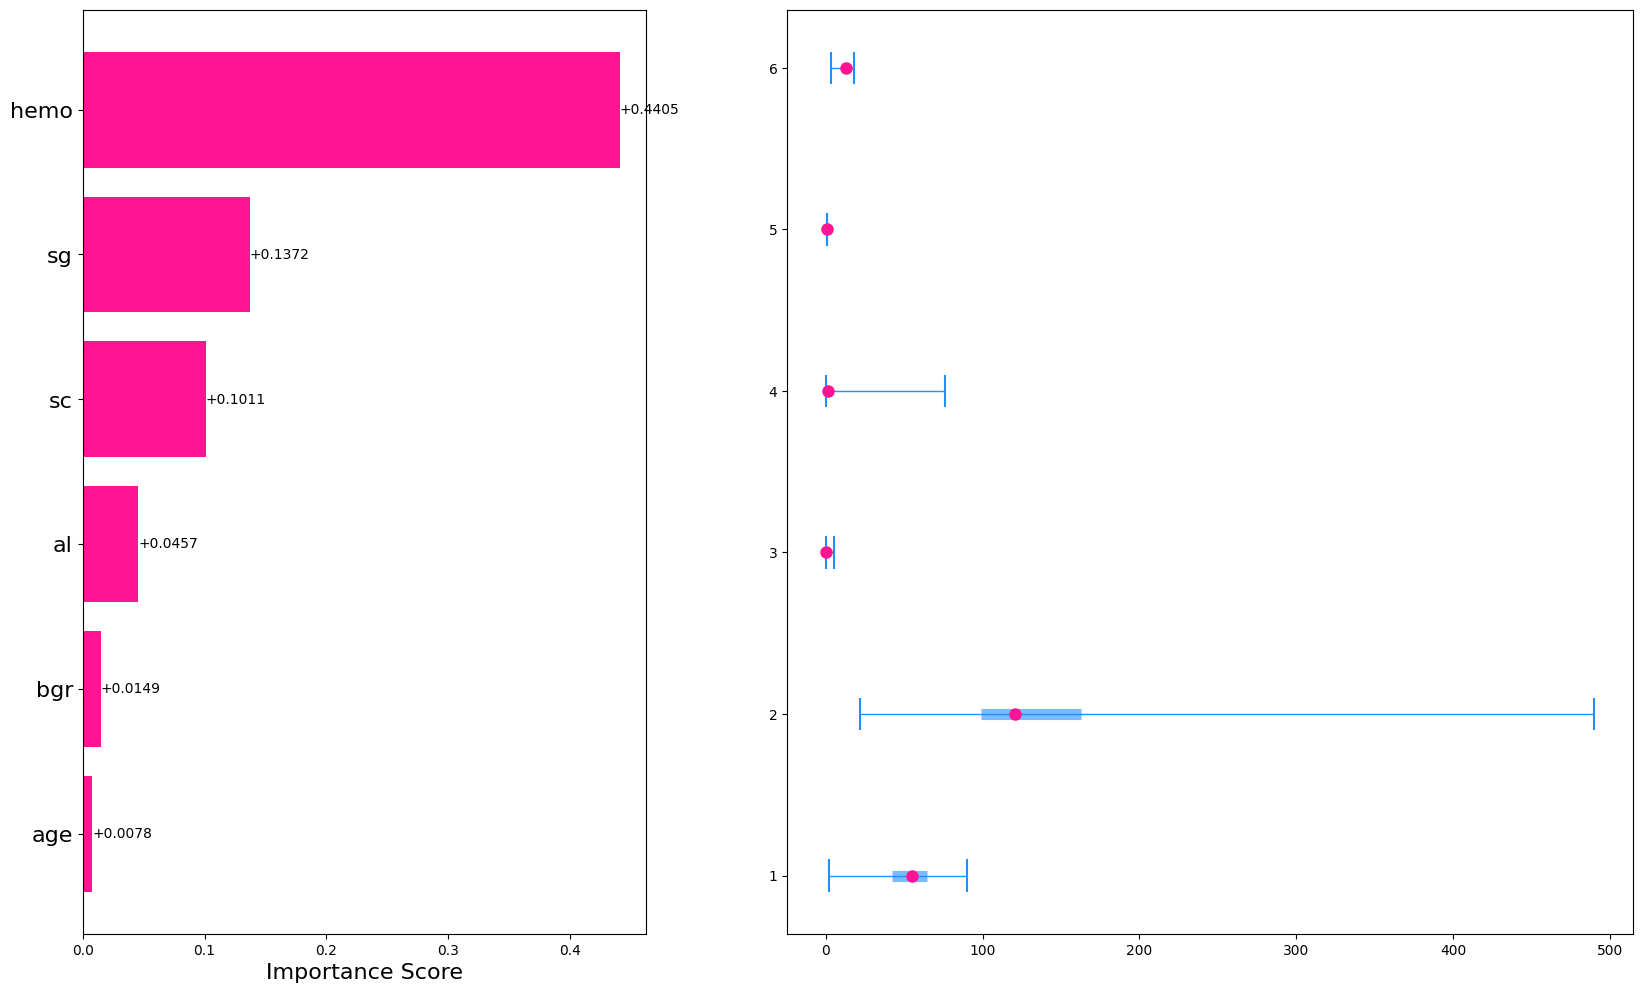

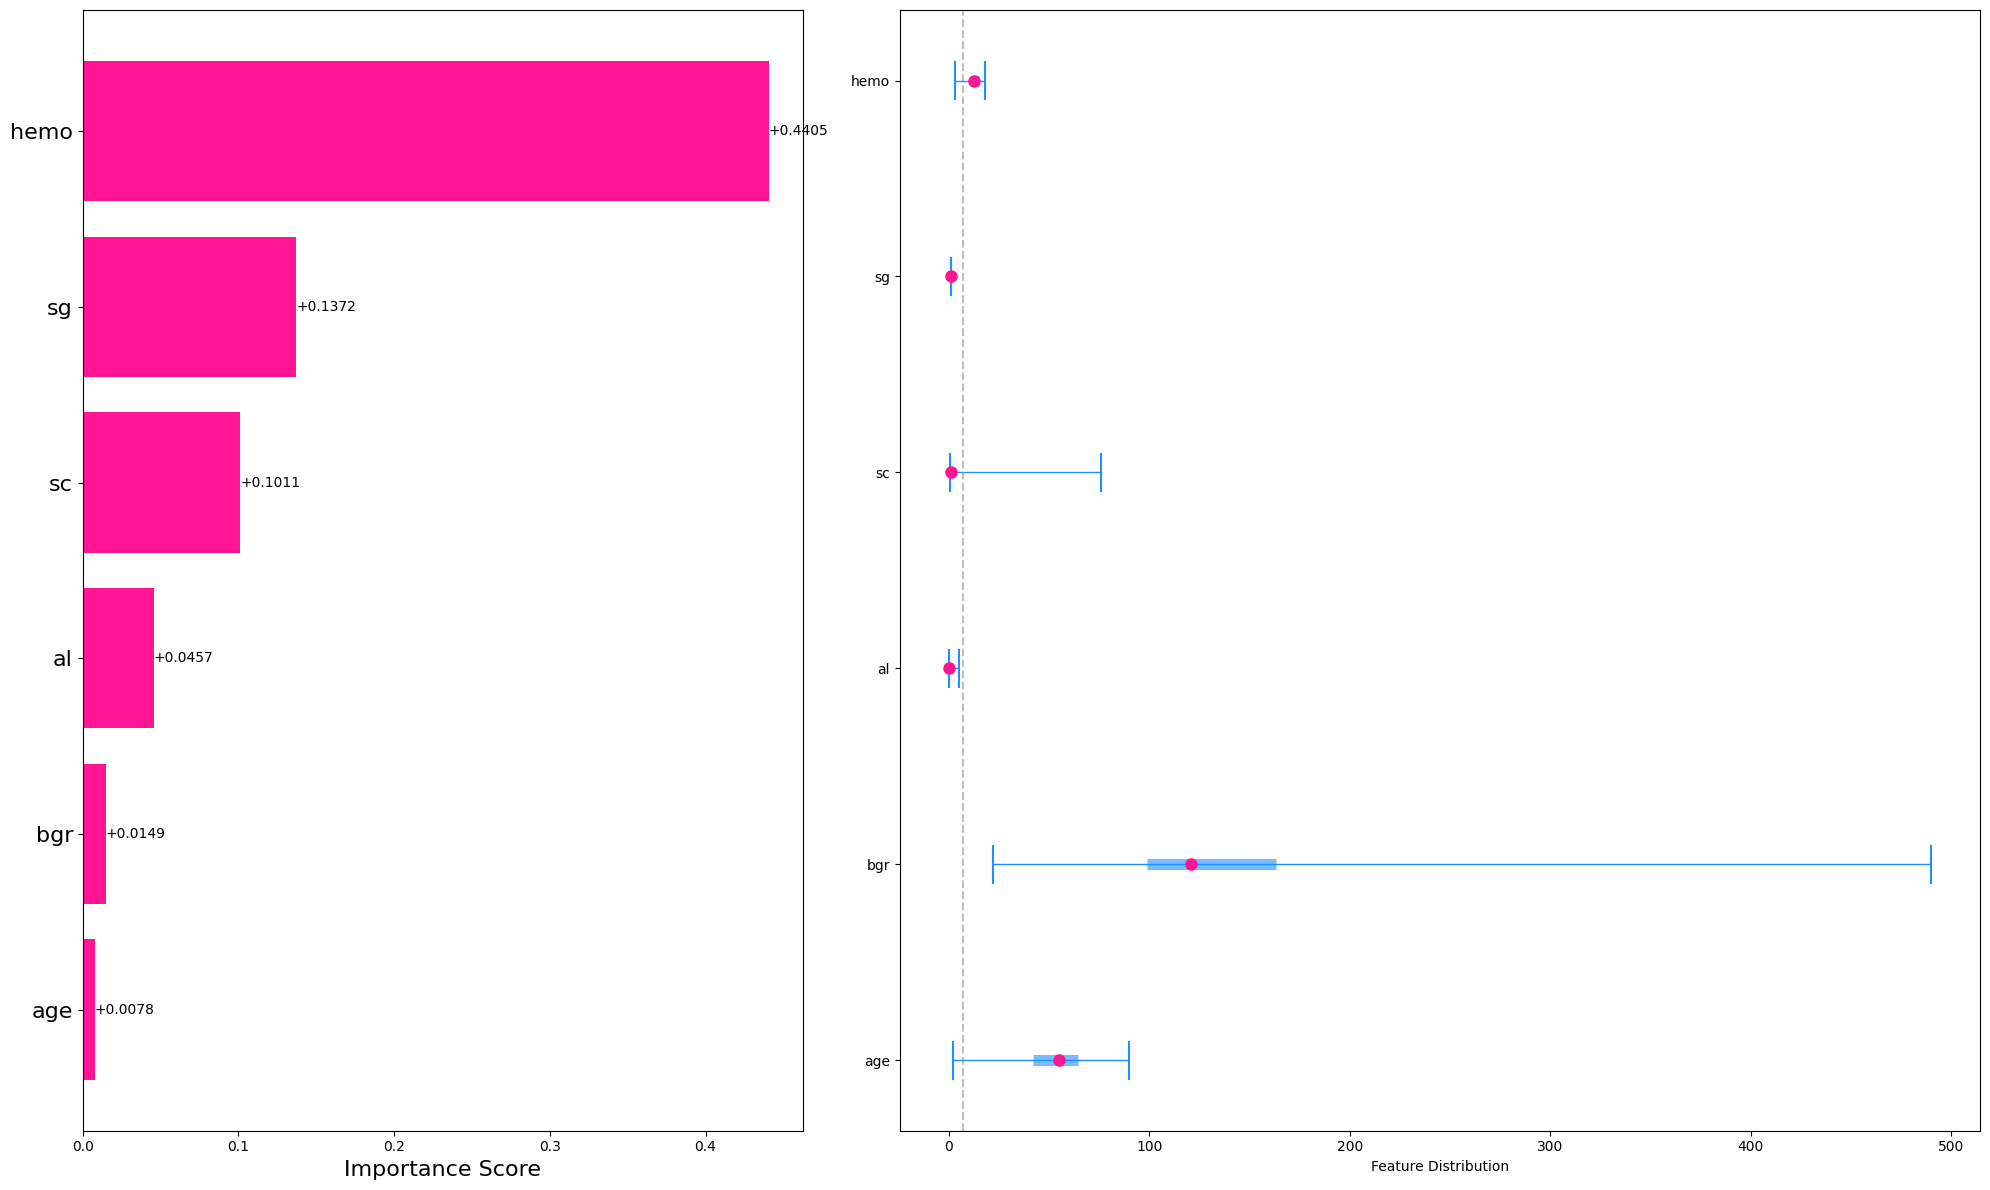

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_importance_with_distribution(feature_importance_dict, feature_statistics):
    """
    Creates a visualization of feature importance with distribution statistics for kidney disease analysis.
    
    Parameters:
    -----------
    feature_importance_dict : dict
        Dictionary containing feature names and their importance values
    feature_statistics : dict
        Dictionary containing feature statistics (min, Q1, median, Q3, max)
    """
    # Convert feature importance to DataFrame
    df = pd.DataFrame(list(feature_importance_dict.items()), 
                     columns=['feature', 'importance'])
    df = df.sort_values('importance', ascending=True)
    
    # Create the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), 
                                  gridspec_kw={'width_ratios': [1, 1.5]})
    
    # Plot 1: Feature Importance Bar Chart
    y_pos = np.arange(len(df))
    ax1.barh(y_pos, df['importance'], color='#FF1493')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(df['feature'],fontsize=16)
    ax1.set_xlabel('Importance Score',fontsize=16)
  
    
    # Add value annotations to the bars
    for i, v in enumerate(df['importance']):
        ax1.text(v, i, f'+{v:.4f}', va='center')
    
    # Plot 2: Feature Distribution Summary
    features = df['feature'].tolist()
    
    # Create box-like visualization using statistics
    positions = np.arange(1, len(features) + 1)
    for i, feature in enumerate(features):
        if feature in feature_statistics:
            stats = feature_statistics[feature]
            
            # Plot the box
            ax2.hlines(positions[i], stats['Q1'], stats['Q3'], color='#1E90FF', linewidth=8, alpha=0.6)
            ax2.hlines(positions[i], stats['Min'], stats['Max'], color='#1E90FF', linewidth=1)
            ax2.vlines(stats['Min'], positions[i]-0.1, positions[i]+0.1, color='#1E90FF')
            ax2.vlines(stats['Max'], positions[i]-0.1, positions[i]+0.1, color='#1E90FF')
            ax2.plot(stats['Median'], positions[i], 'o', color='#FF1493', markersize=8)
    
    # Set y-ticks and labels
    ax2.set_yticks(positions)
    ax2.set_yticklabels(features)
    
    # Add vertical line at median of medians
    median_of_medians = np.median([stats['Median'] for stats in feature_statistics.values()])
    ax2.axvline(x=median_of_medians, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and title
    ax2.set_xlabel('Feature Distribution')
    
    
    plt.tight_layout()
    return fig

# Example usage with your data:
# Create dictionary of feature importances from your data
feature_importance = {
    'hemo': 0.4405,
    'sg': 0.1372,
    'sc': 0.1011,
    'al': 0.0457,
    'bgr': 0.0149,
    'age': 0.0078
}

# Create dictionary of feature statistics from your data
feature_statistics = {
    'sg': {'Min': 1.00, 'Q1': 1.01, 'Median': 1.02, 'Q3': 1.02, 'Max': 1.02},
    'al': {'Min': 0.00, 'Q1': 0.00, 'Median': 0.00, 'Q3': 2.00, 'Max': 5.00},
    'bgr': {'Min': 22.00, 'Q1': 99.00, 'Median': 121.00, 'Q3': 163.00, 'Max': 490.00},
    'hemo': {'Min': 3.10, 'Q1': 10.30, 'Median': 12.65, 'Q3': 15.00, 'Max': 17.80},
    'age': {'Min': 2.00, 'Q1': 42.00, 'Median': 55.00, 'Q3': 64.50, 'Max': 90.00},
    'sc': {'Min': 0.40, 'Q1': 0.90, 'Median': 1.30, 'Q3': 2.80, 'Max': 76.00}
}

# Create the visualization
fig = plot_feature_importance_with_distribution(feature_importance, feature_statistics)
plt.show()




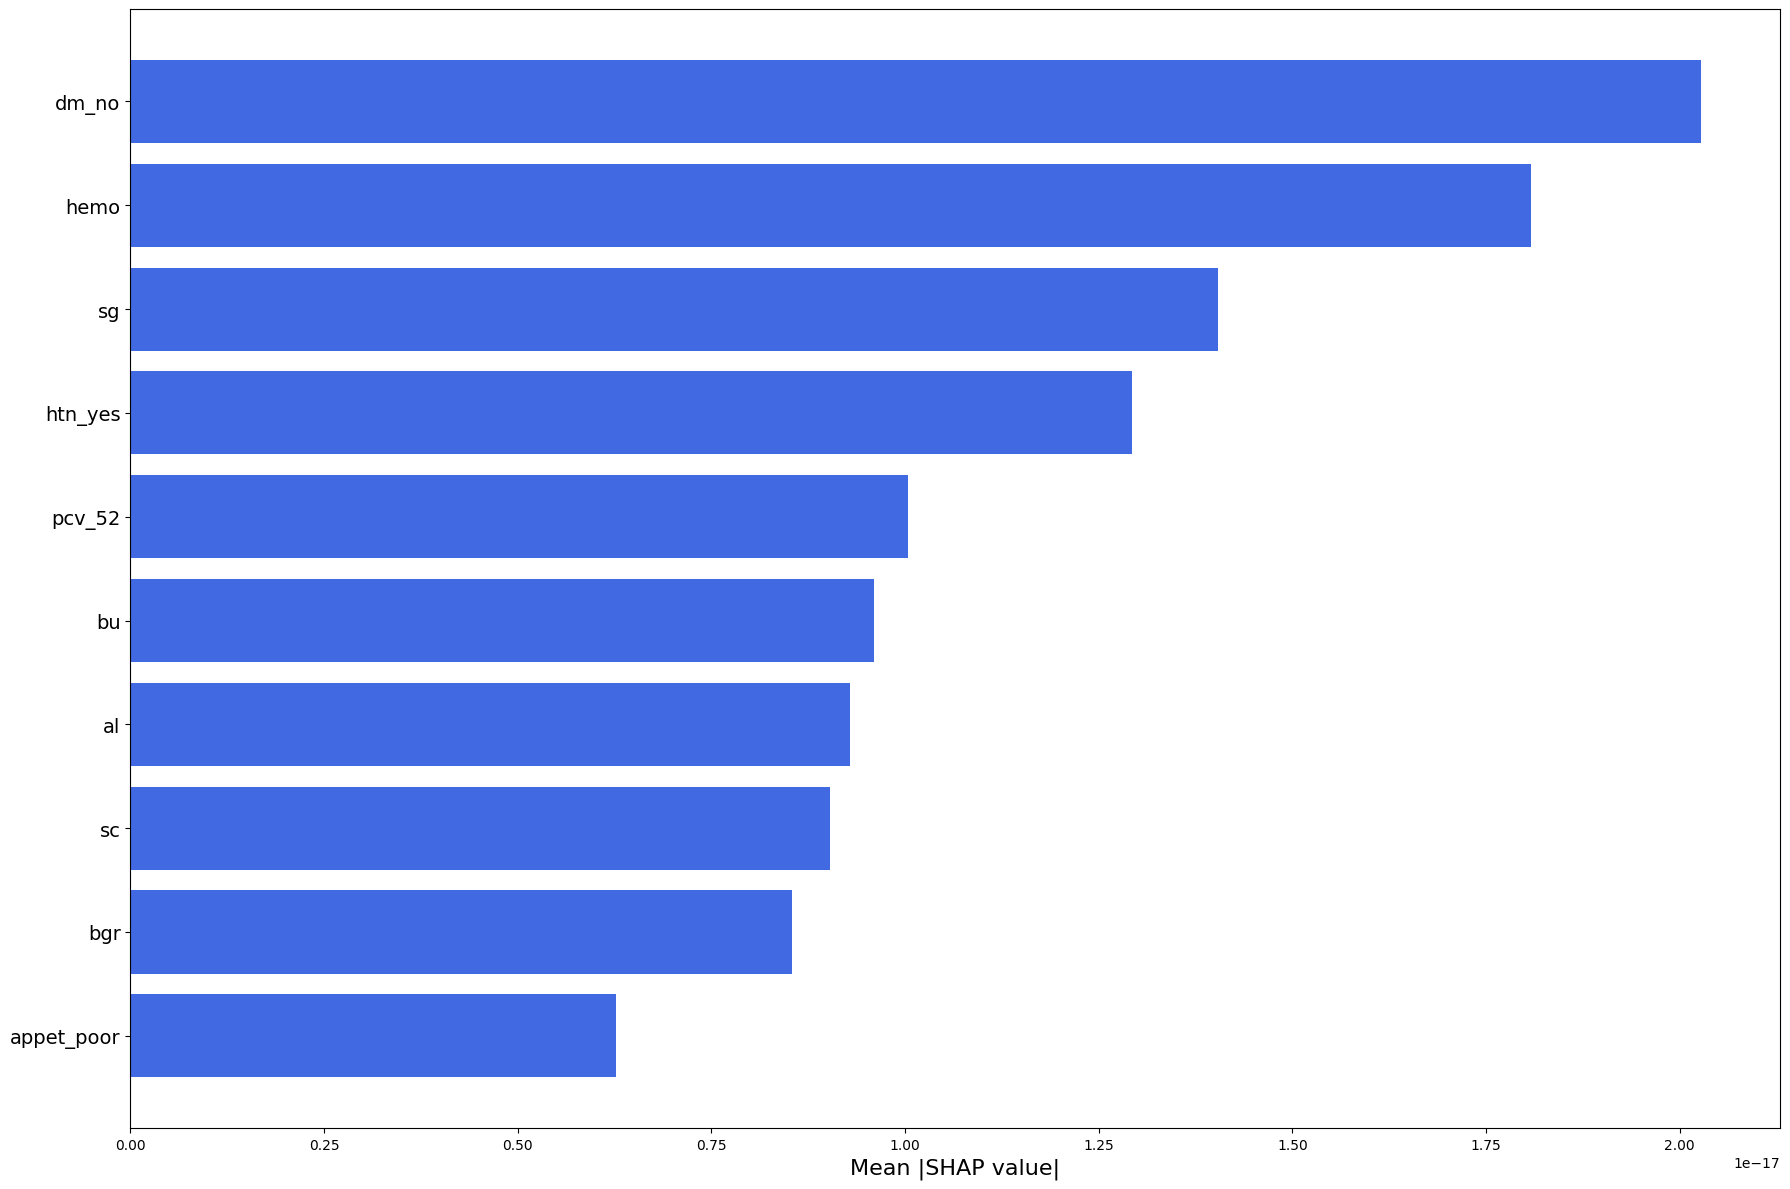

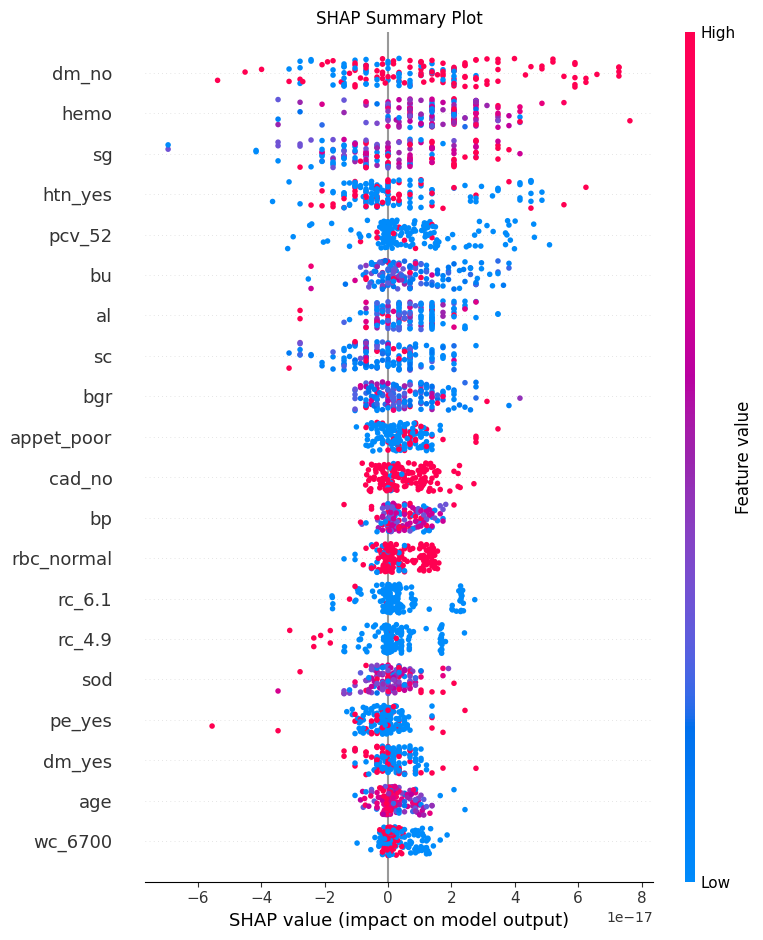

<Figure size 800x600 with 0 Axes>

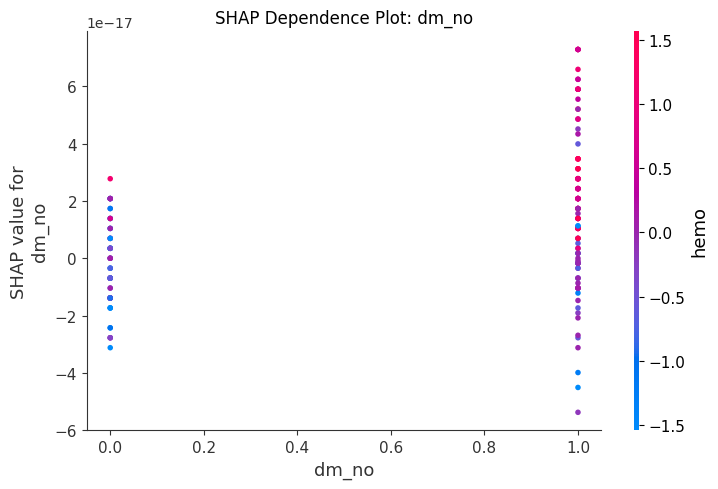

<Figure size 800x600 with 0 Axes>

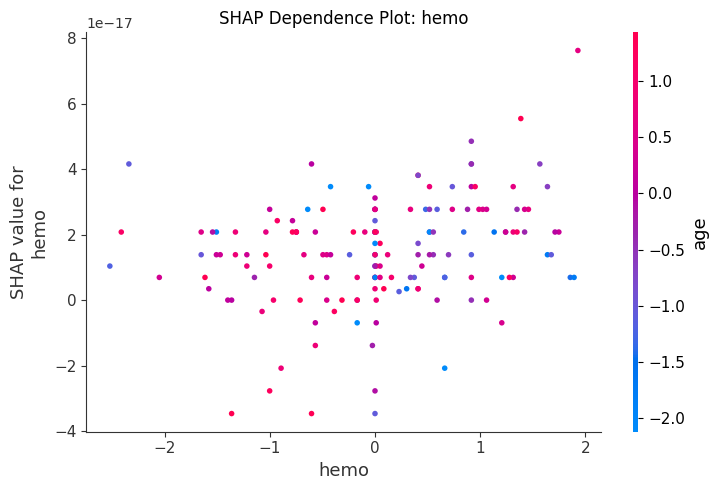

<Figure size 800x600 with 0 Axes>

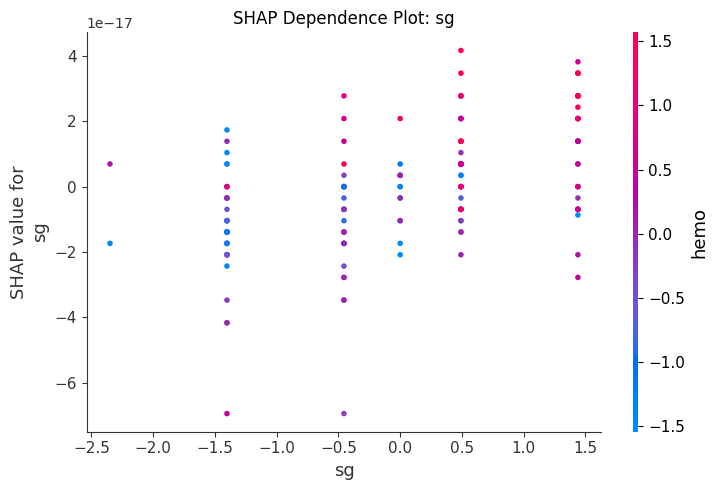

In [8]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def create_comprehensive_shap_analysis(model, X_train, X_test, preprocessor=None, original_features=None):
    """
    Creates a comprehensive set of SHAP visualizations for model interpretation.
    Now handles feature names from the preprocessor.
    
    Parameters:
    -----------
    model : sklearn estimator
        Fitted model to analyze
    X_train : array-like
        Training data
    X_test : array-like
        Test data
    preprocessor : ColumnTransformer, optional
        Fitted preprocessor that was used to transform the data
    original_features : list, optional
        List of original feature names from the dataset
    """
    plt.style.use('default')
    
    # Ensure data is in the right format (dense array)
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else np.array(X_test)
    
    # Get feature names from preprocessor if available
    if preprocessor is not None and original_features is not None:
        # Get numeric features
        numeric_features = [f for f in original_features 
                          if f in preprocessor.named_transformers_['num']
                          .get_feature_names_out().tolist()]
        
        # Get encoded categorical features
        categorical_features = []
        if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
            cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
            categorical_features.extend(cat_features)
        
        feature_names = numeric_features + categorical_features
    else:
        # Fallback to generic feature names
        feature_names = [f"Feature_{i}" for i in range(X_test_dense.shape[1])]
    
    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    try:
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test_dense)
        
        # Handle multi-class SHAP values
        if isinstance(shap_values, list):
            if len(shap_values) == 2:  # Binary classification
                shap_values = shap_values[1]
            else:  # Multi-class - take mean across classes
                shap_values = np.mean(shap_values, axis=0)
        
        # Handle 3D SHAP values
        if shap_values.ndim == 3:
            shap_values = np.mean(shap_values, axis=2)
        
        # Calculate mean absolute SHAP values
        mean_shap = np.abs(shap_values).mean(axis=0)
        
        # Create DataFrame with feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(mean_shap)],
            'Importance': mean_shap
        }).sort_values('Importance', ascending=True)
        
        # 1. Feature Importance Plot
        plt.figure(figsize=(18, 12))  # Adjusted figure size for better readability
        plt.barh(range(10), feature_importance_df.nlargest(10, 'Importance')['Importance'], color='royalblue')
        plt.yticks(range(10), feature_importance_df.nlargest(10, 'Importance')['Feature'], fontsize=14)
        plt.xlabel('Mean |SHAP value|', fontsize=16)
        plt.gca().invert_yaxis()  # Show the most important feature at the top
        plt.tight_layout()
        plt.show()


        # 2. SHAP Summary Plot
        plt.figure(figsize=(12, 8))
        if shap_values.ndim == 2:
            shap.summary_plot(
                shap_values,
                X_test_dense,
                feature_names=feature_names[:X_test_dense.shape[1]],
                show=False
            )
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.show()
        plt.close()

        # 3. Top Feature Dependence Plots
        top_features_idx = np.argsort(-mean_shap)[:3]
        
        for idx in top_features_idx:
            feature_name = feature_names[idx]
            plt.figure(figsize=(8, 6))
            if shap_values.ndim == 2:
                shap.dependence_plot(
                    idx,
                    shap_values,
                    X_test_dense,
                    feature_names=feature_names[:X_test_dense.shape[1]],
                    show=False
                )
            plt.title(f'SHAP Dependence Plot: {feature_name}')
            plt.tight_layout()
            plt.show()
            plt.close()

        return {
            'shap_values': shap_values,
            'feature_importance': feature_importance_df,
            'explainer': explainer,
            'feature_names': feature_names
        }
    
    except Exception as e:
        print(f"Error in SHAP analysis: {str(e)}")
        print(f"Shape of X_test_dense: {X_test_dense.shape}")
        print(f"Number of feature names: {len(feature_names)}")
        raise

# Usage example:
# First create and fit the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=66,
    max_depth=25,
    min_samples_split=9,
    random_state=42
)
rf_model.fit(X_train_preprocessed, y_train)

# Then run the SHAP analysis with the preprocessor and original feature names
original_features = X.columns.tolist()  # Get original feature names from your dataset
results = create_comprehensive_shap_analysis(
    rf_model,
    X_train_preprocessed,
    X_test_preprocessed,
    preprocessor=preprocessor,
    original_features=original_features
)




  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

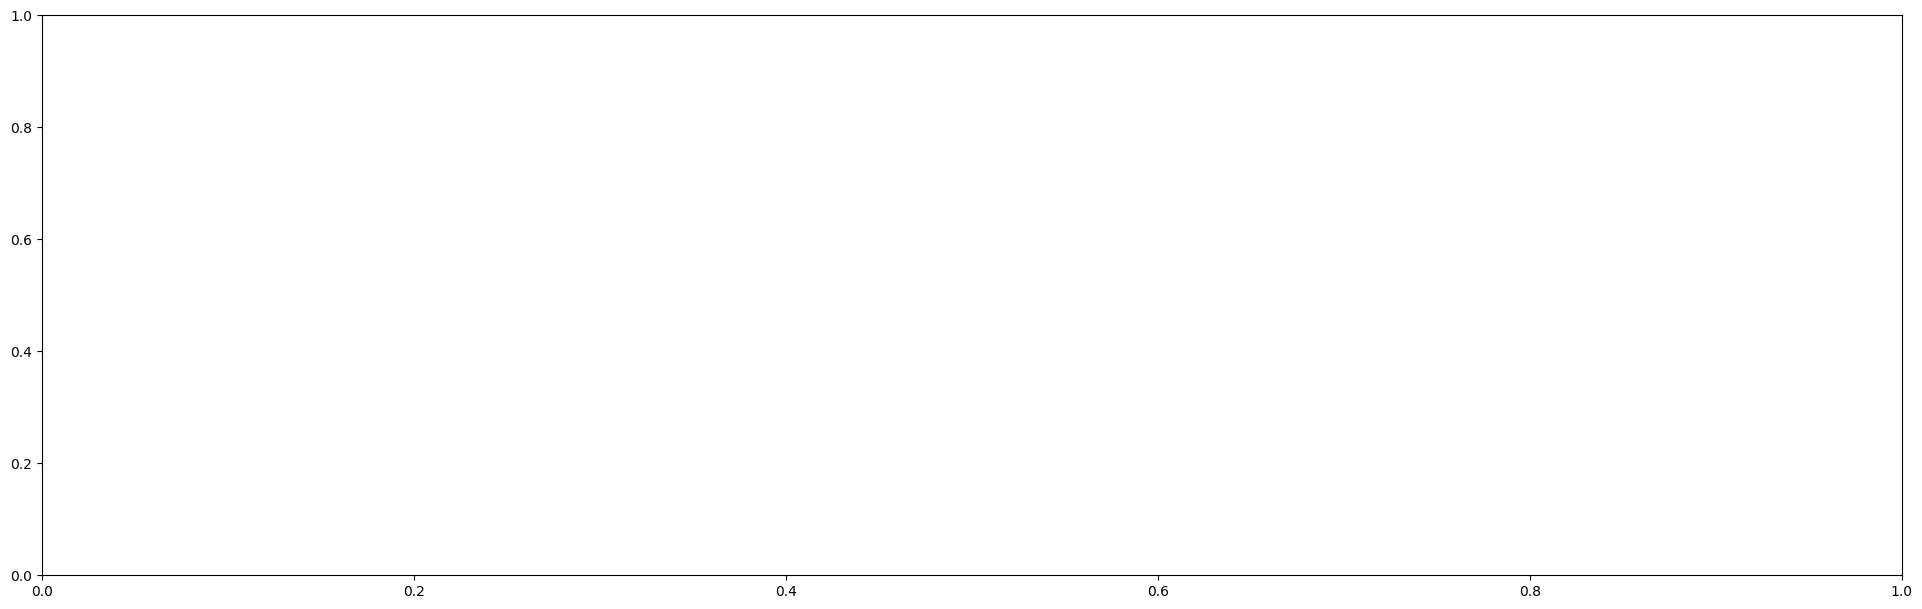

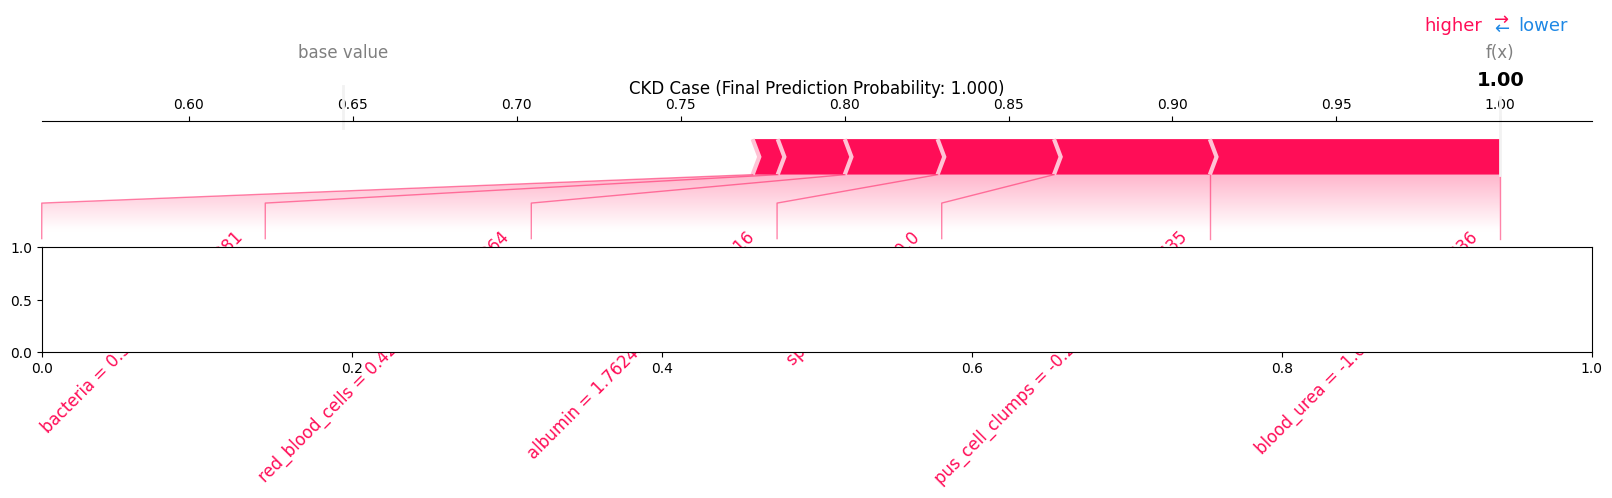

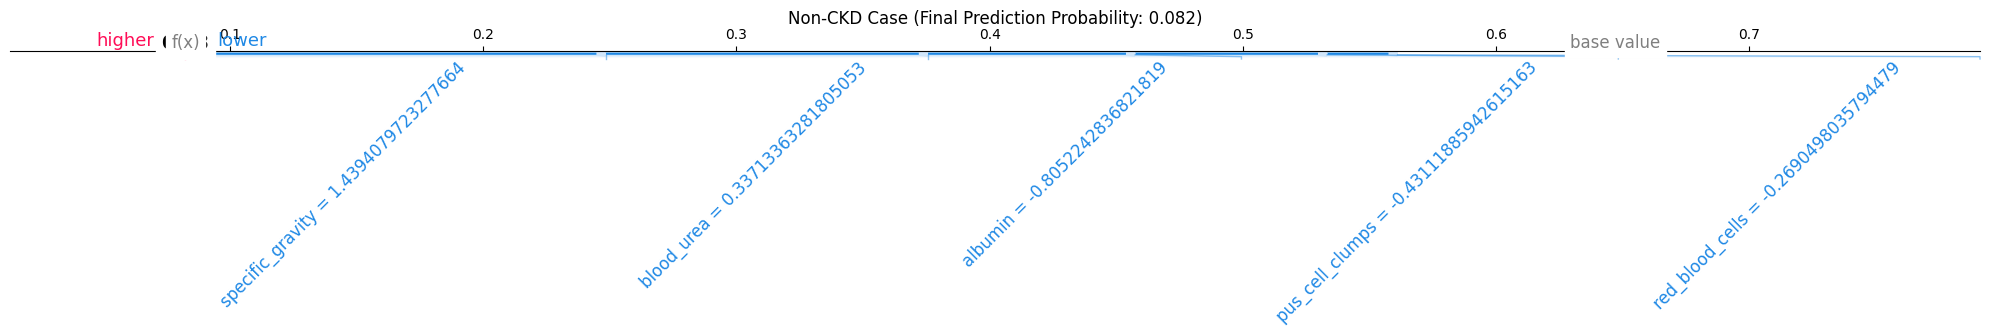


Detailed Prediction Information:
--------------------------------------------------
CKD Case:
Prediction Probability: 1.000
Final Classification: CKD

Non-CKD Case:
Prediction Probability: 0.082
Final Classification: Not CKD


In [9]:
def create_shap_force_plots_multiple(model, X_test_preprocessed, y_test, feature_names):
    """
    Create SHAP force plots for multiple CKD and non-CKD cases with final predictions.
    
    Parameters:
    model: trained model (optimized with RFE)
    X_test_preprocessed: preprocessed test features (after RFE)
    y_test: test labels
    feature_names: list of actual feature names
    """
    # Convert data to numpy array if it isn't already
    X_test_preprocessed = np.array(X_test_preprocessed)
    
    # Create a background dataset for the explainer
    background_data = shap.sample(X_test_preprocessed, 100)
    
    # Get the underlying model
    if hasattr(model, 'best_estimator_'):
        model_to_explain = model.best_estimator_
    else:
        model_to_explain = model
    
    # Create the explainer with predict_proba
    explainer = shap.KernelExplainer(
        lambda x: model_to_explain.predict_proba(x)[:, 1],
        background_data
    )
    
    # Find indices for CKD and non-CKD cases
    ckd_indices = np.where(y_test == 1)[0]
    nonckd_indices = np.where(y_test == 0)[0]
    
    # Select multiple instances of each class
    n_samples = 2  # Number of samples per class
    ckd_samples = X_test_preprocessed[ckd_indices[:n_samples]].astype(np.float64)
    nonckd_samples = X_test_preprocessed[nonckd_indices[:n_samples]].astype(np.float64)
    
    # Calculate SHAP values for all samples
    shap_values_ckd = explainer.shap_values(ckd_samples)
    shap_values_nonckd = explainer.shap_values(nonckd_samples)
    
    # Get probabilities for all samples
    ckd_probs = model_to_explain.predict_proba(ckd_samples)[:, 1]
    nonckd_probs = model_to_explain.predict_proba(nonckd_samples)[:, 1]
    
    # Create figure
    plt.figure(figsize=(24, 16))
    
    # Plot CKD cases
    plt.subplot(2, 1, 1)
    shap.force_plot(
        explainer.expected_value,
        shap_values_ckd[1],  # Second CKD case
        ckd_samples[1],
        feature_names=feature_names,
        matplotlib=True,
        show=False,
        text_rotation=45
    )
    plt.title(f"CKD Case (Final Prediction Probability: {ckd_probs[1]:.3f})", pad=20)
    
    # Plot non-CKD cases
    plt.subplot(2, 1, 2)
    shap.force_plot(
        explainer.expected_value,
        shap_values_nonckd[1],  # Second non-CKD case
        nonckd_samples[1],
        feature_names=feature_names,
        matplotlib=True,
        show=False,
        text_rotation=45
    )
    plt.title(f"Non-CKD Case (Final Prediction Probability: {nonckd_probs[1]:.3f})", pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional information about the predictions
    print("\nDetailed Prediction Information:")
    print("-" * 50)
    print("CKD Case:")
    print(f"Prediction Probability: {ckd_probs[1]:.3f}")
    print(f"Final Classification: {'CKD' if ckd_probs[1] > 0.5 else 'Not CKD'}")
    print("\nNon-CKD Case:")
    print(f"Prediction Probability: {nonckd_probs[1]:.3f}")
    print(f"Final Classification: {'CKD' if nonckd_probs[1] > 0.5 else 'Not CKD'}")

# Run the analysis:
try:
    # Get the RFE-transformed test data
    X_test_rfe = rfe_selector.transform(X_test_preprocessed)
    
    # Get feature names selected by RFE
    selected_features_mask = rfe_selector.support_
    
    # Get original feature names from your dataset
    original_features = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 
                        'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
                        'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
                        'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
                        'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia']
    
    # Select only the feature names that were selected by RFE
    selected_features = [name for name, selected in zip(original_features, selected_features_mask) if selected]
    
    # Get the best Random Forest model
    best_rf_model = optimized_models["Random Forest"]
    
    # Create and display the force plots with actual feature names
    create_shap_force_plots_multiple(best_rf_model, X_test_rfe, y_test, selected_features)
    
except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nShape of X_test_rfe:", X_test_rfe.shape)
    print("Type of X_test_rfe:", type(X_test_rfe))
    print("Data type of X_test_rfe:", X_test_rfe.dtype)


    

learing curve

Display Results and Learning Curves

In [10]:
from sklearn.metrics import classification_report

# Display results for all random states and feature selection methods
for random_state, results in all_results.items():
    print(f"\nResults for random_state={random_state}:")
    for (method, model_name), accuracy in results.items():
        # Retrieve the corresponding model and data
        model = models[model_name]
        X_train_fs, X_test_fs = None, None
        if method == "SelectKBest":
            k_best_selector = SelectKBest(score_func=f_classif, k=10)
            X_train_fs = k_best_selector.fit_transform(preprocessor.fit_transform(X_train), y_train)
            X_test_fs = k_best_selector.transform(preprocessor.transform(X_test))
        elif method == "RFE":
            rfe_selector = RFE(estimator=RandomForestClassifier(random_state=random_state), n_features_to_select=10)
            X_train_fs = rfe_selector.fit_transform(preprocessor.fit_transform(X_train), y_train)
            X_test_fs = rfe_selector.transform(preprocessor.transform(X_test))

        # Train the model on the selected features
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)

        # Display accuracy
        print(f"  {method} - {model_name}: {accuracy * 100:.2f}%")

        # Display classification report
        print(classification_report(y_test, y_pred))



Results for random_state=42:
  SelectKBest - Random Forest: 98.12%


C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.97      0.98       100

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

  SelectKBest - Gradient Boosting: 98.75%


C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

  SelectKBest - AdaBoost: 98.12%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Desoky\

  SelectKBest - Support Vector Machine: 98.75%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.97      0.98       100

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

  SelectKBest - Logistic Regression: 98.12%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

  SelectKBest - Decision Tree: 98.12%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.97      0.98       100

    accuracy                           0.98       160

C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - Random Forest: 100.00%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.97      0.98       100

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - Gradient Boosting: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00       100

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - AdaBoost: 98.75%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - Support Vector Machine: 97.50%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - Logistic Regression: 98.12%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  RFE - Decision Tree: 98.75%
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.98      0.99       100

    accuracy                           0.99       160
   macro avg       0.98      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

  RFE - K-Nearest Neighbors: 97.50%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       1.00      0.96      0.98       100

    accuracy                           0.97       160
   macro avg       0.97      0.98      0.97       160
weighted avg       0.98      0.97      0.98       160



C:\Users\Desoky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
